In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-alpha0
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
sklearn 0.20.3
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [3]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [6]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                     activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

sklearn_model = KerasRegressor(
    build_fn = build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs = 10,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 83us/sample - loss: 1.4329 - val_loss: 0.7654
Epoch 2/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.6528 - val_loss: 0.6674
Epoch 3/10
11610/11610 [==============================] - 1s 53us/sample - loss: 0.6594 - val_loss: 0.7570
Epoch 4/10
11610/11610 [==============================] - 1s 50us/sample - loss: 1.1426 - val_loss: 0.7110
Epoch 5/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5703 - val_loss: 0.5765
Epoch 6/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5263 - val_loss: 0.5544
Epoch 7/10
11610/11610 [==============================] - 1s 52us/sample - loss: 0.5052 - val_loss: 0.5334
Epoch 8/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.4915 - val_loss: 0.5176
Epoch 9/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4800 - val_l

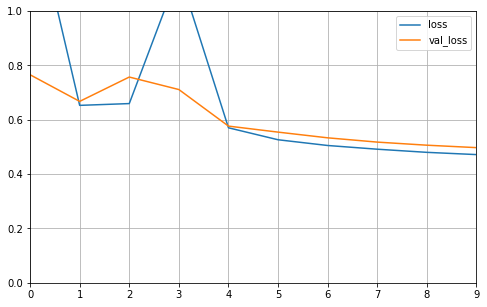

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [8]:
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 10,
                                      cv = 3,
                                      n_jobs = 1)
random_search_cv.fit(x_train_scaled, y_train, epochs = 100,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)

# cross_validation: 训练集分成n份，n-1训练，最后一份验证.

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 91us/sample - loss: 3.0039 - val_loss: 2.2811
Epoch 2/100
7740/7740 [==============================] - 0s 62us/sample - loss: 1.5413 - val_loss: 1.4473
Epoch 3/100
7740/7740 [==============================] - 1s 70us/sample - loss: 1.0946 - val_loss: 1.1101
Epoch 4/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.9134 - val_loss: 0.9604
Epoch 5/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.8287 - val_loss: 0.8837
Epoch 6/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.7808 - val_loss: 0.8373
Epoch 7/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.7491 - val_loss: 0.8040
Epoch 8/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.7265 - val_loss: 0.7803
Epoch 9/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.7079 - val_loss: 0.758

7740/7740 [==============================] - 0s 48us/sample - loss: 0.5916 - val_loss: 0.6467
Epoch 23/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5867 - val_loss: 0.6414
Epoch 24/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5821 - val_loss: 0.6362
Epoch 25/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5775 - val_loss: 0.6312
Epoch 26/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.5730 - val_loss: 0.6262
Epoch 27/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.5687 - val_loss: 0.6213
Epoch 28/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5645 - val_loss: 0.6163
Epoch 29/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5604 - val_loss: 0.6118
Epoch 30/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5564 - val_loss: 0.6071
Epoch 31/100
7740/7740 [==========================

Epoch 36/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.4879 - val_loss: 0.5373
Epoch 37/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.4857 - val_loss: 0.5349
Epoch 38/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.4837 - val_loss: 0.5326
Epoch 39/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.4817 - val_loss: 0.5303
Epoch 40/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.4799 - val_loss: 0.5279
Epoch 41/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.4781 - val_loss: 0.5258
Epoch 42/100
7740/7740 [==============================] - 1s 68us/sample - loss: 0.4763 - val_loss: 0.5237
Epoch 43/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.4746 - val_loss: 0.5217
Epoch 44/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.4730 - val_loss: 0.5198
Epoch 45/100
7740/7740 [=============

Epoch 6/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.6688 - val_loss: 0.7190
Epoch 7/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.6474 - val_loss: 0.6987
Epoch 8/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6303 - val_loss: 0.6822
Epoch 9/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.6164 - val_loss: 0.6684
Epoch 10/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.6039 - val_loss: 0.6558
Epoch 11/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5929 - val_loss: 0.6450
Epoch 12/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5828 - val_loss: 0.6345
Epoch 13/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5735 - val_loss: 0.6248
Epoch 14/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5650 - val_loss: 0.6156
Epoch 15/100
7740/7740 [=================

7740/7740 [==============================] - 1s 95us/sample - loss: 0.4769 - val_loss: 0.5298
Epoch 35/100
7740/7740 [==============================] - 1s 111us/sample - loss: 0.4741 - val_loss: 0.5261
Epoch 36/100
7740/7740 [==============================] - 1s 107us/sample - loss: 0.4713 - val_loss: 0.5234
Epoch 37/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.4687 - val_loss: 0.5199
Epoch 38/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4663 - val_loss: 0.5170
Epoch 39/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.4638 - val_loss: 0.5139
Epoch 40/100
7740/7740 [==============================] - 1s 71us/sample - loss: 0.4615 - val_loss: 0.5109
Epoch 41/100
7740/7740 [==============================] - 1s 74us/sample - loss: 0.4593 - val_loss: 0.5086
Epoch 42/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4570 - val_loss: 0.5061
Epoch 43/100
7740/7740 [=======================

Epoch 53/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.4844 - val_loss: 0.5037
Epoch 54/100
7740/7740 [==============================] - 0s 20us/sample - loss: 0.4818
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 77us/sample - loss: 4.1616 - val_loss: 2.8693
Epoch 2/100
7740/7740 [==============================] - 0s 48us/sample - loss: 2.0823 - val_loss: 1.6558
Epoch 3/100
7740/7740 [==============================] - 0s 49us/sample - loss: 1.3308 - val_loss: 1.1835
Epoch 4/100
7740/7740 [==============================] - 0s 48us/sample - loss: 1.0181 - val_loss: 0.9821
Epoch 5/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.8704 - val_loss: 0.8831
Epoch 6/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.7927 - val_loss: 0.8278
Epoch 7/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.7473 - val_loss: 0.7940
Epoch 8/100
774

7740/7740 [==============================] - 0s 51us/sample - loss: 0.6766 - val_loss: 0.7496
Epoch 11/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6667 - val_loss: 0.7398
Epoch 12/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6584 - val_loss: 0.7313
Epoch 13/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6512 - val_loss: 0.7238
Epoch 14/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6446 - val_loss: 0.7174
Epoch 15/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6385 - val_loss: 0.7107
Epoch 16/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6327 - val_loss: 0.7044
Epoch 17/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.6272 - val_loss: 0.6984
Epoch 18/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.6219 - val_loss: 0.6929
Epoch 19/100
7740/7740 [==========================

Epoch 21/100
7740/7740 [==============================] - 1s 68us/sample - loss: 1.1541 - val_loss: 1.1881
Epoch 22/100
7740/7740 [==============================] - 1s 74us/sample - loss: 1.1278 - val_loss: 1.1590
Epoch 23/100
7740/7740 [==============================] - 1s 65us/sample - loss: 1.0989 - val_loss: 1.1276
Epoch 24/100
7740/7740 [==============================] - 0s 56us/sample - loss: 1.0674 - val_loss: 1.0934
Epoch 25/100
7740/7740 [==============================] - 0s 56us/sample - loss: 1.0334 - val_loss: 1.0570
Epoch 26/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.9977 - val_loss: 1.0193
Epoch 27/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.9612 - val_loss: 0.9816
Epoch 28/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.9254 - val_loss: 0.9460
Epoch 29/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.8934 - val_loss: 0.9151
Epoch 30/100
7740/7740 [=============

Epoch 31/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5363 - val_loss: 0.5668
Epoch 32/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.5330 - val_loss: 0.5628
Epoch 33/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5296 - val_loss: 0.5593
Epoch 34/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5266 - val_loss: 0.5553
Epoch 35/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5235 - val_loss: 0.5519
Epoch 36/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.5205 - val_loss: 0.5487
Epoch 37/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5177 - val_loss: 0.5453
Epoch 38/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.5150 - val_loss: 0.5422
Epoch 39/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.5124 - val_loss: 0.5392
Epoch 40/100
7740/7740 [=============

Epoch 53/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.7604 - val_loss: 0.8021
Epoch 54/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.7499 - val_loss: 0.7907
Epoch 55/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.7397 - val_loss: 0.7796
Epoch 56/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.7301 - val_loss: 0.7694
Epoch 57/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.7208 - val_loss: 0.7598
Epoch 58/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.7119 - val_loss: 0.7504
Epoch 59/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.7036 - val_loss: 0.7419
Epoch 60/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6960 - val_loss: 0.7340
Epoch 61/100
7740/7740 [==============================] - 0s 56us/sample - loss: 0.6888 - val_loss: 0.7262
Epoch 62/100
7740/7740 [=============

Epoch 28/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.4052 - val_loss: 0.4205
Epoch 29/100
7740/7740 [==============================] - 1s 72us/sample - loss: 0.4017 - val_loss: 0.4165
Epoch 30/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.3991 - val_loss: 0.4120
Epoch 31/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3957 - val_loss: 0.4090
Epoch 32/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3930 - val_loss: 0.4059
Epoch 33/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.3900 - val_loss: 0.4032
Epoch 34/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.3876 - val_loss: 0.4011
Epoch 35/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.3852 - val_loss: 0.3975
Epoch 36/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.3829 - val_loss: 0.3960
Epoch 37/100
7740/7740 [=============

Epoch 22/100
7740/7740 [==============================] - 1s 134us/sample - loss: 0.4326 - val_loss: 0.4760
Epoch 23/100
7740/7740 [==============================] - 1s 141us/sample - loss: 0.4282 - val_loss: 0.4723
Epoch 24/100
7740/7740 [==============================] - 1s 120us/sample - loss: 0.4239 - val_loss: 0.4672
Epoch 25/100
7740/7740 [==============================] - 1s 102us/sample - loss: 0.4199 - val_loss: 0.4621
Epoch 26/100
7740/7740 [==============================] - 1s 120us/sample - loss: 0.4157 - val_loss: 0.4565
Epoch 27/100
7740/7740 [==============================] - 1s 146us/sample - loss: 0.4121 - val_loss: 0.4533
Epoch 28/100
7740/7740 [==============================] - 1s 123us/sample - loss: 0.4086 - val_loss: 0.4476
Epoch 29/100
7740/7740 [==============================] - 1s 132us/sample - loss: 0.4053 - val_loss: 0.4449
Epoch 30/100
7740/7740 [==============================] - 1s 149us/sample - loss: 0.4019 - val_loss: 0.4429
Epoch 31/100
7740/7740 [====

7740/7740 [==============================] - 0s 30us/sample - loss: 0.4731
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 114us/sample - loss: 2.9217 - val_loss: 1.8761
Epoch 2/100
7740/7740 [==============================] - 1s 67us/sample - loss: 1.3641 - val_loss: 1.1319
Epoch 3/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.9540 - val_loss: 0.9213
Epoch 4/100
7740/7740 [==============================] - 0s 63us/sample - loss: 0.8238 - val_loss: 0.8446
Epoch 5/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.7687 - val_loss: 0.8087
Epoch 6/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.7385 - val_loss: 0.7860
Epoch 7/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.7172 - val_loss: 0.7679
Epoch 8/100
7740/7740 [==============================] - 1s 68us/sample - loss: 0.7001 - val_loss: 0.7527
Epoch 9/100
7740/7740 [=====

7740/7740 [==============================] - 1s 69us/sample - loss: 0.5781 - val_loss: 0.6420
Epoch 19/100
7740/7740 [==============================] - 1s 72us/sample - loss: 0.5704 - val_loss: 0.6336
Epoch 20/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.5634 - val_loss: 0.6256
Epoch 21/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.5565 - val_loss: 0.6181
Epoch 22/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.5501 - val_loss: 0.6112
Epoch 23/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.5441 - val_loss: 0.6045
Epoch 24/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5383 - val_loss: 0.5980
Epoch 25/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.5330 - val_loss: 0.5918
Epoch 26/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.5278 - val_loss: 0.5865
Epoch 27/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 58us/sample - loss: 0.5779 - val_loss: 0.6153
Epoch 7/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5510 - val_loss: 0.5866
Epoch 8/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5321 - val_loss: 0.5713
Epoch 9/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.5168 - val_loss: 0.5508
Epoch 10/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.5038 - val_loss: 0.5364
Epoch 11/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.4939 - val_loss: 0.5260
Epoch 12/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.4854 - val_loss: 0.5168
Epoch 13/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.4788 - val_loss: 0.5080
Epoch 14/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.4718 - val_loss: 0.5017
Epoch 15/100
7740/7740 [=============================

7740/7740 [==============================] - 0s 54us/sample - loss: 1.3215 - val_loss: 1.3829
Epoch 9/100
7740/7740 [==============================] - 0s 51us/sample - loss: 1.3215 - val_loss: 1.3828
Epoch 10/100
7740/7740 [==============================] - 0s 51us/sample - loss: 1.3215 - val_loss: 1.3827
Epoch 11/100
7740/7740 [==============================] - 0s 52us/sample - loss: 1.3215 - val_loss: 1.3826
Epoch 12/100
7740/7740 [==============================] - 0s 52us/sample - loss: 1.3215 - val_loss: 1.3826
Epoch 13/100
7740/7740 [==============================] - 0s 23us/sample - loss: 1.3214
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 76us/sample - loss: 3.2002 - val_loss: 1.8771
Epoch 2/100
7740/7740 [==============================] - 0s 52us/sample - loss: 1.4968 - val_loss: 1.4513
Epoch 3/100
7740/7740 [==============================] - 0s 51us/sample - loss: 1.3367 - val_loss: 1.3971
Epoch 4/100
7740/7740 [==

Epoch 2/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.5679 - val_loss: 0.6030
Epoch 3/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.5146 - val_loss: 0.5424
Epoch 4/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.4834 - val_loss: 0.5178
Epoch 5/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.4627 - val_loss: 0.4981
Epoch 6/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.4460 - val_loss: 0.4802
Epoch 7/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.4340 - val_loss: 0.4684
Epoch 8/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.4242 - val_loss: 0.4550
Epoch 9/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.4158 - val_loss: 0.4459
Epoch 10/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.4094 - val_loss: 0.4382
Epoch 11/100
7740/7740 [=====================

7740/7740 [==============================] - 0s 48us/sample - loss: 0.6897 - val_loss: 0.7491
Epoch 12/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6785 - val_loss: 0.7383
Epoch 13/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6680 - val_loss: 0.7283
Epoch 14/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.6584 - val_loss: 0.7187
Epoch 15/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6493 - val_loss: 0.7096
Epoch 16/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.6409 - val_loss: 0.7004
Epoch 17/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6329 - val_loss: 0.6918
Epoch 18/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6253 - val_loss: 0.6835
Epoch 19/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6182 - val_loss: 0.6755
Epoch 20/100
7740/7740 [==========================

Epoch 26/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5837 - val_loss: 0.6444
Epoch 27/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5796 - val_loss: 0.6401
Epoch 28/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5756 - val_loss: 0.6356
Epoch 29/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5720 - val_loss: 0.6311
Epoch 30/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5688 - val_loss: 0.6285
Epoch 31/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5656 - val_loss: 0.6253
Epoch 32/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5625 - val_loss: 0.6224
Epoch 33/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.5597 - val_loss: 0.6196
Epoch 34/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5569 - val_loss: 0.6169
Epoch 35/100
7740/7740 [=============

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x13159f748>,
          fit_params=None, iid='warn', n_iter=10, n_jobs=1,
          param_distributions={'hidden_layers': [1, 2, 3, 4], 'layer_size': array([ 1,  2, ..., 98, 99]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1326c1e48>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [9]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 4, 'layer_size': 44, 'learning_rate': 0.0009577195482517434}
-0.38287415603026553


In [10]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

5160/5160 [==============================] - 0s 30us/sample - loss: 0.3790


0.3790317230446394